In [1274]:
from fast_autocomplete import AutoComplete
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
import numpy as np
from nltk.tag.perceptron import PerceptronTagger
from nltk.tag import hmm
import difflib
import more_itertools as mit
import random
import pickle
import seaborn as sn
import time

In [1275]:
habit=1#if 1.. use habit data

if 'fold_data' in globals():
    del fold_data
fold_data=[]

if habit==0:
    with open("fold_data.txt", "rb") as fp:   # Unpickling
        fold_data = pickle.load(fp)
    
else:
    with open("fold_data_h.txt","rb") as fp:
        fold_data=pickle.load(fp)

In [1276]:
if 'data' in globals():
    del data
data=[]
for i in range(len(fold_data)):
    data.extend(fold_data[i])

In [1277]:
# [[drugname(s)],[route(s)], dose, units, starting, frequency,
# min,max, duration, for whom, header, dose description,
# dose description to be changed]

tagorder=['DN','DO','UN','ST','FR','RO','MA','MI','DU']

words={}
allwords={} #allwords with noise
for i in range(len(data)):
    for j in range(len(tagorder)):
        if data[i][j]!='':
            words[str(data[i][j]).lower()]=tagorder[j]
        if data[i][j+9]!='':
            allwords[str(data[i][j+9].lower())]=tagorder[j]

In [1278]:
print(reversdict.keys())

dict_keys(['DN', 'DO', 'UN', 'ST', 'FR', 'RO', 'DU', 'MA', 'MI'])


# Data Analysis

In [1279]:
reversdict=nltk.Index((value,key) for (key,value) in allwords.items())
counts=nltk.defaultdict(int)
classwordnumbers=[]
for tag in reversdict:
    counts[tag]=len(reversdict[tag])
    classwordnumbers.append([])
    for words in reversdict[tag]:
        classwordnumbers[-1].append(len(re.findall(" ",words))+1)

In [1280]:
allclasswordnumbers=[]
for i in range(len(classwordnumbers)):
    allclasswordnumbers.extend(classwordnumbers[i])

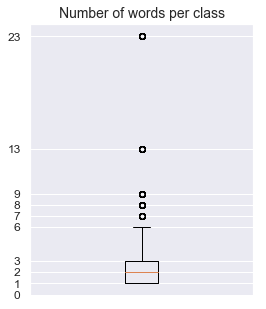

In [1281]:
fig1, ax1 = plt.subplots(figsize=(4,5))
ax1.set_title('Number of words per class',fontdict={'fontsize':14})
ax1.boxplot(allclasswordnumbers)

#plt.xticks([1,2,3,4,5,6,7,8,9], objects,fontsize=12)
plt.xticks([])
plt.yticks([0,1,2,3,6,7,8,9,13,23],fontsize=12)
plt.grid(True)
fig1.savefig("words_per_class.jpg")

In [1282]:
'DN', 'DO', 'UN', 'ST', 'FR', 'RO', 'MA', 'DU', 'MI'
print("DO: always one word")
print(classwordnumbers[1].count(1))
print()
print("UN: always one word")
print(classwordnumbers[2].count(1))
print()
print("ST:")
print(str(classwordnumbers[3].count(2)) + " times 2 word")
print(str(classwordnumbers[3].count(3)) + " times 3 words")
print()

print("DU:")
print(str(classwordnumbers[7].count(1))+ " times 1 word")
print(str(classwordnumbers[7].count(2))+ " times 2 words")
print()

print("RO:")
print(str(classwordnumbers[5].count(1))+ " times 1 words")
print(str(classwordnumbers[5].count(2))+ " times 2 words")
print()

print("MI: always three words")
print(classwordnumbers[8].count(3))

print()

print("DN:")
print("min: "+str(min(classwordnumbers[0])))
print("mean: "+str(round(np.mean(classwordnumbers[0]),2)))
print("median: "+str(np.median(classwordnumbers[0])))
print("max: "+str(max(classwordnumbers[0])))
print("n: "+str(len(classwordnumbers[0])))
print()

print("FR:")
print("min: "+str(min(classwordnumbers[4])))
print("mean: "+str(round(np.mean(classwordnumbers[4]),2)))
print("median: "+str(np.median(classwordnumbers[4])))
print("max: "+str(max(classwordnumbers[4])))
print("n: "+str(len(classwordnumbers[4])))
print()

print("MA:")
print("min: "+str(min(classwordnumbers[6])))
print("mean: "+str(round(np.mean(classwordnumbers[6]),2)))
print("median: "+str(np.median(classwordnumbers[6])))
print("max: "+str(max(classwordnumbers[6])))
print("n: "+str(len(classwordnumbers[6])))



DO: always one word
736

UN: always one word
804

ST:
2925 times 2 word
971 times 3 words

DU:
0 times 1 word
40 times 2 words

RO:
465 times 1 words
34 times 2 words

MI: always three words
142

DN:
min: 1
mean: 1.71
median: 1.0
max: 8
n: 6106

FR:
min: 1
mean: 2.86
median: 3.0
max: 5
n: 2638

MA:
min: 2
mean: 2.0
median: 2.0
max: 2
n: 752


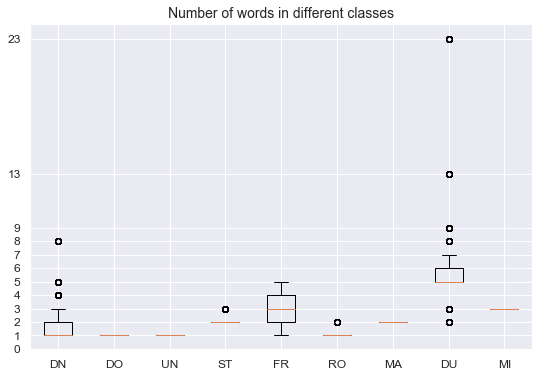

In [1283]:
fig1, ax1 = plt.subplots(figsize=(9,6))
ax1.set_title('Number of words in different classes',fontdict={'fontsize':14})
ax1.boxplot(classwordnumbers)#,vert=False)

plt.xticks([1,2,3,4,5,6,7,8,9], objects,fontsize=12)

plt.yticks([0,1,2,3,4,5,6,7,8,9,13,23],fontsize=12)
plt.grid(True)
fig1.savefig("data_analysis.jpg")


In [1284]:
allprescriptions=[] #noise words tagged
allrealprescriptions=[] #unnoised words tagged

for l in range(2):
    allpre=[]
    for k in range(len(data)):
        currtuple=[]
        currorder=data[k][18]

        #make tuples 
        currinp=[(data[k][0+9*l],'DN'),(' '.join(data[k][1+9*l:3+9*l]),'DO')]
        for i in range(6):
            currinp.append( (data[k][i+3+l*9],tagorder[i+3]))

        #order all tuples
        for i in range(len(currorder)):
            currtuple.append(currinp[int(currorder[i])])

        #split DO and UN:
        for i in range(len(currtuple)):
            if currtuple[i][1]=="DO" and len(currtuple[i][0].split())==2:
                splitup=currtuple[i][0].split()
                currtuple[i]=(splitup[0],'DO')
                currtuple.insert(i+1,(splitup[1],'UN'))

        #make single word tuples and delete '' tuples
        finaltuple=[]
        for i in range(len(currtuple)):
            if currtuple[i][0]!='':
                splitup=currtuple[i][0].split()
                for j in range(len(splitup)):
                    finaltuple.append((splitup[j].lower(),currtuple[i][1]))

        allpre.append(finaltuple)
    if l==0:
        allrealprescriptions=allpre
    else:
        allprescriptions=allpre

In [1285]:
if habit==0:
    with open("allpre.txt", "wb") as fp:   #Pickling
        pickle.dump(allprescriptions, fp)

    with open("allrealpre.txt", "wb") as fp:   #Pickling
        pickle.dump(allrealprescriptions, fp)
else:
    with open("allpre_h.txt", "wb") as fp:   #Pickling
        pickle.dump(allprescriptions, fp)

    with open("allrealpre_h.txt", "wb") as fp:   #Pickling
        pickle.dump(allrealprescriptions, fp)


# General Train + Test:


In [1286]:
if 'general_train_data' in globals():
    del general_train_data
if 'general_test_data' in globals():
    del general_test_data

general_train_data=[]
general_test_data=[]

for i in range(len(fold_data)):
    general_test_data.append(allprescriptions[(i)*len(fold_data[0]):(i+1)*len(fold_data[0])])
    curr_train_data=[]
    for j in range(len(fold_data)):
        if j!=i:
            curr_train_data.extend(allprescriptions[(j)*len(fold_data[0]):(j+1)*len(fold_data[0])])
    general_train_data.append(curr_train_data)

In [1288]:
analysis=0

if analysis==1:
    all_time=[]
    all_osr=[]

    start_time = time.time()
    acc=[]
    for i in range(10):
        train_data=general_train_data[i]
        g0t=nltk.DefaultTagger('DN')
        tagg=nltk.NgramTagger(1,train=train_data,backoff=g0t)
        acc.append(tagg.evaluate(general_test_data[i]))
    print("unigram tagger OSR: "+str(sum(acc)/len(acc)))
    print("--- %s seconds ---" % (time.time() - start_time))
    all_time.append(time.time()-start_time)
    all_osr.append(sum(acc)/len(acc))
    print()

    start_time = time.time()
    acc=[]
    for i in range(10):
        train_data=general_train_data[i]
        g0t=nltk.DefaultTagger('DN')
        g1t=nltk.NgramTagger(1,train=train_data,backoff=g0t)
        tagg=nltk.NgramTagger(2,train=train_data,backoff=g1t)
        acc.append(tagg.evaluate(general_test_data[i]))
    print("bigram tagger OSR: "+str(sum(acc)/len(acc))) 
    print("--- %s seconds ---" % (time.time() - start_time))
    all_time.append(time.time()-start_time)
    all_osr.append(sum(acc)/len(acc))
    print()

    start_time = time.time()
    acc=[]
    for i in range(10):
        train_data=general_train_data[i]
        g0t=nltk.DefaultTagger('DN')
        g1t=nltk.NgramTagger(1,train=train_data,backoff=g0t)
        g2t=nltk.NgramTagger(2,train=train_data,backoff=g1t)
        tagg=nltk.NgramTagger(3,train=train_data,backoff=g2t)
        acc.append(tagg.evaluate(general_test_data[i]))
    print("trigram tagger OSR: "+str(sum(acc)/len(acc)))
    print("--- %s seconds ---" % (time.time() - start_time))
    all_time.append(time.time()-start_time)
    all_osr.append(sum(acc)/len(acc))
    print()

    start_time = time.time()
    acc=[]
    for i in range(10):
        train_data=general_train_data[i]
        g0t=nltk.DefaultTagger('DN')
        g1t=nltk.NgramTagger(1,train=train_data,backoff=g0t)
        g2t=nltk.NgramTagger(2,train=train_data,backoff=g1t)
        g3t=nltk.NgramTagger(3,train=train_data,backoff=g2t)
        tagg=nltk.NgramTagger(4,train=train_data,backoff=g3t)
        acc.append(tagg.evaluate(general_test_data[i]))
    print("4-gram tagger OSR: "+str(sum(acc)/len(acc)))
    print("--- %s seconds ---" % (time.time() - start_time))
    all_time.append(time.time()-start_time)
    all_osr.append(sum(acc)/len(acc))
    print()

    start_time = time.time()
    acc=[]
    for i in range(10):
        train_data=general_train_data[i]
        g0t=nltk.DefaultTagger('DN')
        g1t=nltk.NgramTagger(1,train=train_data,backoff=g0t)
        g2t=nltk.NgramTagger(2,train=train_data,backoff=g1t)
        g3t=nltk.NgramTagger(3,train=train_data,backoff=g2t)
        g4t=nltk.NgramTagger(4,train=train_data,backoff=g3t)
        tagg=nltk.NgramTagger(5,train=train_data,backoff=g4t)
        acc.append(tagg.evaluate(general_test_data[i]))
    print("5-gram tagger OSR: "+str(sum(acc)/len(acc)))
    print("--- %s seconds ---" % (time.time() - start_time))
    all_time.append(time.time()-start_time)
    all_osr.append(sum(acc)/len(acc))
    print()

    start_time = time.time()
    acc=[]
    for i in range(10):
        train_data=general_train_data[i]
        g0t=nltk.DefaultTagger('DN')
        g1t=nltk.NgramTagger(1,train=train_data,backoff=g0t)
        g2t=nltk.NgramTagger(2,train=train_data,backoff=g1t)
        g3t=nltk.NgramTagger(3,train=train_data,backoff=g2t)
        g4t=nltk.NgramTagger(4,train=train_data,backoff=g3t)
        g5t=nltk.NgramTagger(5,train=train_data,backoff=g4t)
        tagg=nltk.NgramTagger(6,train=train_data,backoff=g5t)
        acc.append(tagg.evaluate(general_test_data[i]))
    print("6-gram tagger OSR: "+str(sum(acc)/len(acc)))
    print("--- %s seconds ---" % (time.time() - start_time))
    all_time.append(time.time()-start_time)
    all_osr.append(sum(acc)/len(acc))
    print()

    start_time = time.time()
    acc=[]
    for i in range(10):
        train_data=general_train_data[i]
        g0t=nltk.DefaultTagger('DN')
        g1t=nltk.NgramTagger(1,train=train_data,backoff=g0t)
        g2t=nltk.NgramTagger(2,train=train_data,backoff=g1t)
        g3t=nltk.NgramTagger(3,train=train_data,backoff=g2t)
        g4t=nltk.NgramTagger(4,train=train_data,backoff=g3t)
        g5t=nltk.NgramTagger(5,train=train_data,backoff=g4t)
        g6t=nltk.NgramTagger(6,train=train_data,backoff=g5t)
        tagg=nltk.NgramTagger(7,train=train_data,backoff=g6t)
        acc.append(tagg.evaluate(general_test_data[i]))
    print("7-gram tagger OSR: "+str(sum(acc)/len(acc)))
    print("--- %s seconds ---" % (time.time() - start_time))
    all_time.append(time.time()-start_time)
    all_osr.append(sum(acc)/len(acc))
    print()

    start_time = time.time()
    acc=[]
    for i in range(10):
        train_data=general_train_data[i]
        g0t=nltk.DefaultTagger('DN')
        g1t=nltk.NgramTagger(1,train=train_data,backoff=g0t)
        g2t=nltk.NgramTagger(2,train=train_data,backoff=g1t)
        g3t=nltk.NgramTagger(3,train=train_data,backoff=g2t)
        g4t=nltk.NgramTagger(4,train=train_data,backoff=g3t)
        g5t=nltk.NgramTagger(5,train=train_data,backoff=g4t)
        g6t=nltk.NgramTagger(6,train=train_data,backoff=g5t)
        g7t=nltk.NgramTagger(7,train=train_data,backoff=g6t)
        tagg=nltk.NgramTagger(8,train=train_data,backoff=g7t)
        acc.append(tagg.evaluate(general_test_data[i]))
    print("8-gram tagger OSR: "+str(sum(acc)/len(acc)))
    print("--- %s seconds ---" % (time.time() - start_time))
    all_time.append(time.time()-start_time)
    all_osr.append(sum(acc)/len(acc))
    print()

    start_time = time.time()
    acc=[]
    for i in range(10):
        train_data=general_train_data[i]
        g0t=nltk.DefaultTagger('DN')
        g1t=nltk.NgramTagger(1,train=train_data,backoff=g0t)
        g2t=nltk.NgramTagger(2,train=train_data,backoff=g1t)
        g3t=nltk.NgramTagger(3,train=train_data,backoff=g2t)
        g4t=nltk.NgramTagger(4,train=train_data,backoff=g3t)
        g5t=nltk.NgramTagger(5,train=train_data,backoff=g4t)
        g6t=nltk.NgramTagger(6,train=train_data,backoff=g5t)
        g7t=nltk.NgramTagger(7,train=train_data,backoff=g6t)
        g8t=nltk.NgramTagger(8,train=train_data,backoff=g7t)
        tagg=nltk.NgramTagger(9,train=train_data,backoff=g8t)
        acc.append(tagg.evaluate(general_test_data[i]))
    print("9-gram tagger OSR: "+str(sum(acc)/len(acc)))
    print("--- %s seconds ---" % (time.time() - start_time))
    all_time.append(time.time()-start_time)
    all_osr.append(sum(acc)/len(acc))
    
    x=range(1,10)

    fig, ax1 = plt.subplots(figsize=(9,5))

    color = 'tab:red'
    ax1.set_xlabel('POS n - gram (10-Fold)')
    ax1.set_ylabel('comp. time (sec.)', color=color)
    ax1.plot(x,all_time, color=color,zorder=1)
    ax1.tick_params(axis='y', labelcolor=color,labelsize=13)
    ax1.tick_params(axis='x',labelsize=13)
    ax1.set_xticks([1,2,3,4,5,6,7,8,9])
    ax1.yaxis.label.set_fontsize(16)
    ax1.xaxis.label.set_fontsize(16)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('OSR', color=color)  # we already handled the x-label with ax1
    ax2.grid(zorder=0)
    ax2.plot(x,all_osr, color=color,zorder=2)
    ax2.tick_params(axis='y', labelcolor=color,labelsize=13)
    ax2.yaxis.label.set_fontsize(16)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    ax2.grid(visible=False)
    plt.show()
    fig.savefig("n_gram_ana.jpg")
    


In [1213]:
def confmatrix(tagger,train_data,test_data):
    tagorder=['DN','DO','UN','ST','FR','RO','MA','MI','DU']
    confmatcurr=np.zeros((9,9))
    error_mat=[]
    true_mat=[]
    
    if tagger=="hmm":
        trainer = hmm.HiddenMarkovModelTrainer()
        tagg = trainer.train_supervised(train_data)
        
    elif tagger=="ngram":
        g0t=nltk.DefaultTagger('DN')
        g1t=nltk.NgramTagger(1,train=train_data,backoff=g0t)
        tagg=nltk.NgramTagger(2,train=train_data,backoff=g1t)
        #tagg=nltk.NgramTagger(3,train=train_data,backoff=g2t)
                
    elif tagger=="perceptron":
        tagg=PerceptronTagger(load=False)
        tagg.train(train_data)
        
    for i in range(len(test_data)):
        
        currex=[k.lower() for k,j in test_data[i]]
        class_true=[j for k,j in test_data[i]]
        currtag=tagg.tag(currex)
        class_predicted=[j for k,j in currtag]
        
        error=0
        for j in range(len(class_true)):
            confmatcurr[tagorder.index(class_true[j])][tagorder.index(class_predicted[j])]+=1
            if class_true[j]!=class_predicted[j]:
                error=1
                
        if error==1:
            error_mat.append(test_data[i])
            true_mat.append(currtag)
            
    return(confmatcurr,error_mat,true_mat)


In [1214]:
def confmat(tagger):
    confmat_all=[]
    curr_error_mat=[]
    curr_true_mat=[]
    for j in range(len(general_train_data)):
        if tagger=="perceptron":
            currconfmat,error_mat,true_mat=confmatrix(tagger,general_train_data[j],general_test_data[j])
            curr_error_mat.extend(error_mat)
            curr_true_mat.extend(true_mat)
        else:
            currconfmat,_,_=confmatrix(tagger,general_train_data[j],general_test_data[j])
            
        confmat_all.append(currconfmat)
    return (confmat_all,curr_error_mat,curr_true_mat)


In [1215]:
#confusion matrix analysis:
def cm_analysis(cm):
    cm_new=np.divide(cm.T,np.sum(cm,axis=1),out=np.zeros_like(cm.T),where=(np.sum(cm,axis=1))!=0).T
    
    n=np.sum(np.sum(cm))
    
    OSR=np.trace(cm)/n
    
    nTP=np.diag(cm)
    nFP=np.sum(cm,axis=0)-nTP
    nFN=np.sum(cm,axis=1)-nTP
    nTN=np.repeat(n,9)-nTP-nFP-nFN
    
    TPR=np.divide(nTP,(nTP+nFN),out=np.zeros_like(nTP),where=(nTP+nFN)!=0)
    TNR=np.divide(nTN,(nTN+nFP),out=np.zeros_like(nTN),where=(nTN+nFP)!=0)
    PPV=np.divide(nTP,(nTP+nFP),out=np.zeros_like(nTP),where=(nTP+nFP)!=0)
    NPV=np.divide(nTN,(nTN+nFN),out=np.zeros_like(nTN),where=(nTN+nFN)!=0)
    
    F_i=2*np.divide(PPV*TPR,(PPV+TPR),out=np.zeros_like(PPV*TPR),where=(PPV+TPR)!=0)
    
    AAcc=1/9*sum((nTP+nTN)/np.repeat(n,9))
    ER=1/9*sum((nFP+nFN)/np.repeat(n,9))
    
    P=1/9*sum(PPV)
    R=1/9*sum(TPR)
    F=2*(P*R)/(P+R)
    
    return(cm_new.round(2),OSR,AAcc,ER,P,R,F)

In [1216]:
def overall_confmat(tagger):
    confmat_p,curr_error_mat,curr_true_mat=confmat(tagger)
    
    overall_cm=np.zeros((9,9))
    confmat_compl=np.zeros((9,9))
    
    #measures: OSR,AAcc,ER,P,R,F
    measures=[0,0,0,0,0,0]
    for i in range(len(confmat_p)):
        cm,osr,aacc,er,p,r,f=cm_analysis(confmat_p[i])
        curr_measures=[osr,aacc,er,p,r,f]
        overall_cm+=cm
        measures=[measures[i]+curr_measures[i] for i in range(len(measures))]
        confmat_compl+=confmat_p[i]

    overall_cm,_,_,_,_,_,_=cm_analysis(overall_cm)
    measures=np.divide(measures,10)
    return (overall_cm,confmat_compl,curr_error_mat,curr_true_mat,measures)
    

In [1218]:
cm_output_hmm=overall_confmat("hmm")
cm_output_ngram=overall_confmat("ngram")
cm_output_perceptron=overall_confmat("perceptron")

In [1219]:
def cm_plot(array,array_title,tit):
    cm_new=np.divide(array_title.T,np.sum(array_title,axis=1),out=np.zeros_like(array_title.T),where=(np.sum(array_title,axis=1))!=0).T
    
    fig,ax=plt.subplots(figsize=(10,8))
    df_cm = pd.DataFrame(cm_new, tagorder,
                      tagorder)
    sn.set(font_scale=2)#for label size
    labels = (np.asarray(["{0}\n{1:.2f}".format(text,data) for text, data in zip(array_title.flatten().astype(int), cm_new.flatten())])).reshape(9,9)
    sn.heatmap(df_cm, annot=labels,fmt='',annot_kws={"size": 14})# font size
    plt.show()
    fig.savefig(tit+".jpg")

CM HMM Habit:


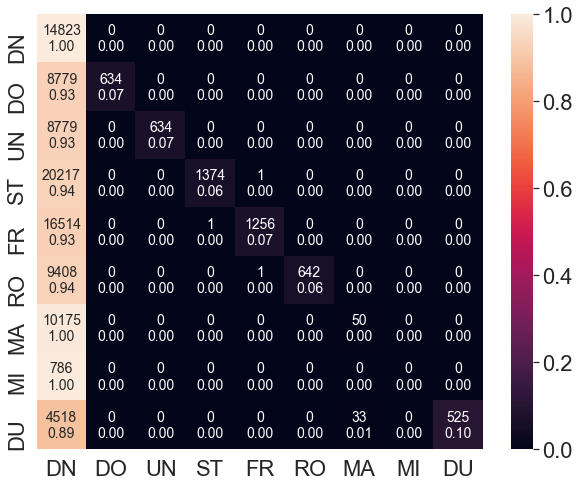

OSR: 0.20328412376122013
AAcc: 0.8229520275024933
ER: 0.17704797249750662
P: 0.5616096203504796
R: 0.156237318189527
F-Score: 0.23140159354470127


In [1220]:
if habit==0:
    print("CM HMM: ")
    cm_plot(cm_output_hmm[0],cm_output_hmm[1],"hmm_cm")
else:
    print("CM HMM Habit:")
    cm_plot(cm_output_hmm[0],cm_output_hmm[1],"hmm_cm_habit")
print("OSR: "+str(cm_output_hmm[-1][0]))
print("AAcc: "+str(cm_output_hmm[-1][1]))
print("ER: "+str(cm_output_hmm[-1][2]))
print("P: "+str(cm_output_hmm[-1][3]))
print("R: "+str(cm_output_hmm[-1][4]))
print("F-Score: "+str(cm_output_hmm[-1][5]))

CM N-gram Habit:


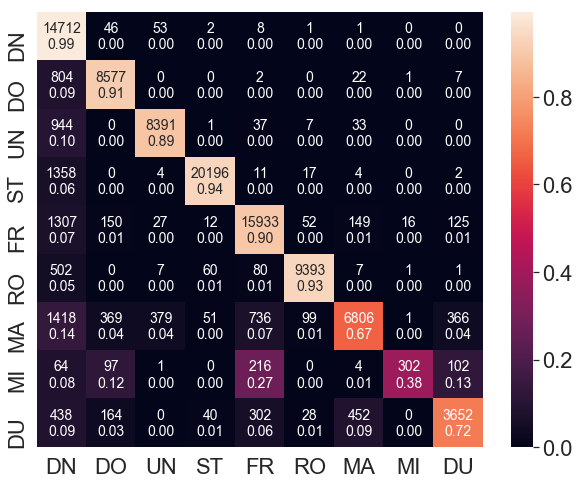

OSR: 0.8894107804486922
AAcc: 0.975424617877487
ER: 0.024575382122512885
P: 0.8115486395285041
R: 0.7719009530769337
F-Score: 0.7908515333232689


In [1221]:
if habit==0:
    print("CM N-gram: ")
    cm_plot(cm_output_ngram[0],cm_output_ngram[1],"ngram_cm")
else:
    print("CM N-gram Habit:")
    cm_plot(cm_output_ngram[0],cm_output_ngram[1],"ngram_cm_habit")
print("OSR: "+str(cm_output_ngram[-1][0]))
print("AAcc: "+str(cm_output_ngram[-1][1]))
print("ER: "+str(cm_output_ngram[-1][2]))
print("P: "+str(cm_output_ngram[-1][3]))
print("R: "+str(cm_output_ngram[-1][4]))
print("F-Score: "+str(cm_output_ngram[-1][5]))

CM Perceptron Habit:


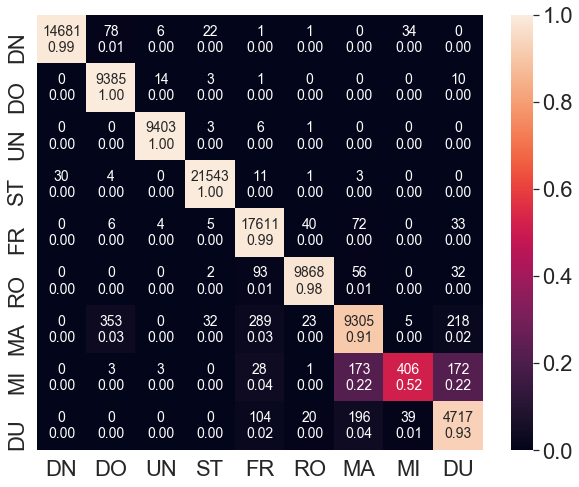

OSR: 0.978864692096803
AAcc: 0.9953032649104004
ER: 0.004696735089599324
P: 0.8776235050486948
R: 0.866791178486434
F-Score: 0.8721193757032427


In [1222]:
if habit==0:
    print("CM Perceptron:")
    cm_plot(cm_output_perceptron[0],cm_output_perceptron[1],"perceptron_cm")
else:
    print("CM Perceptron Habit:")
    cm_plot(cm_output_perceptron[0],cm_output_perceptron[1],"perceptron_cm_habit")
print("OSR: "+str(cm_output_perceptron[-1][0]))
print("AAcc: "+str(cm_output_perceptron[-1][1]))
print("ER: "+str(cm_output_perceptron[-1][2]))
print("P: "+str(cm_output_perceptron[-1][3]))
print("R: "+str(cm_output_perceptron[-1][4]))
print("F-Score: "+str(cm_output_perceptron[-1][5]))

### Tackle mistakes in tagging results:

In [1223]:
print(len(cm_output_perceptron[2]))#at least one mistake
print(str(len(cm_output_perceptron[2])/10000) + "% with min. one missclassification")

1296
0.1296% with min. one missclassification


### How many of the wrong prescriptions are invalid prescriptions?

In [1224]:
def isvalidprescription(prescrip):
    #0.. valid
    #1.. invalid
    
    pos={}
    for j in tagorder:
        pos[j]=[]

    bsp=prescrip
    for i in range(len(bsp)):
        pos[bsp[i][1]].append(i)

    noprescription=0
    for i in tagorder:
        if len(pos[i])>1 and len(pos[i])!=len(range(pos[i][0],pos[i][-1]+1)):
            noprescription=1
    return(noprescription)

In [1225]:
notvalid=0
for err in cm_output_perceptron[2]:
    notvalid+=isvalidprescription(err)

In [1226]:
print(notvalid)

0
